This noteboook will guide you through the creation of a basic system in Springtronics.

# Imports

In [1]:
import sys
sys.path.append('../')

import Springtronics as spr
import matplotlib.pyplot as plt
import numpy as np

# Single oscillator

In [3]:
system = spr.MechanicalSystem()

Variables for the oscillator

In [4]:
m = 1
b= 2
k= 6
force = 1

print(f'Damping coefficient: {b/(2*np.sqrt(k*m))}')

Damping coefficient: 0.4082482904638631


Simulation variables

In [5]:
filelength = 78001
sr = 16000
x = np.linspace(0, filelength/sr, filelength)

In [6]:
dofName = 'oscillator'
system.degreesOfFreedom[f'{dofName}'] = spr.ParametricVariable(m) #creation of the dof
system.degreesOfFreedom[f'{dofName}'].parameterized = True
system.interactionPotentials[f'{dofName}_K'] =  spr.IntegerPotential(k) #spring
system.interactionPotentials[f'{dofName}_K'].strength.parameterized = True
system.interactionPotentials[f'{dofName}_K'].degreesOfFreedom[dofName] = 2
system.interactionPotentials[f'{dofName}_B'] =  spr.LocalDamping(dofName, b) #damping
system.interactionPotentials[f'{dofName}_B'].strength.parameterized = True


In [7]:
system.excitationSources['soundData'] = spr.DirectCInjectionSource(force) #constant force
system.interactionPotentials[f'excitation'] = spr.Excitation('oscillator', 'soundData', 1.0)

In [8]:
#probe
system.probes['oscillator'] = spr.WindowedA2Probe('oscillator',
                                                    startIndex=0,
                                                    endIndex=filelength)

# Define an adjoint source (used to compute the gradient efficiently: https://en.wikipedia.org/wiki/Adjoint_state_method)
system.interactionPotentials['oscillator_probe'] = system.probes['oscillator'].makeAdjointSource()

In [9]:
env = spr.CPPEnvironment(numSteps = filelength,
                           timeStep = 1.0/sr,
                           numSweepSteps = 1,
                           numThreads=1)
#simulation environment

In [10]:
traj = env.getTrajectories(system, deleteTemp=False)

In [11]:
env.getAmplitudes(system)

(array([[0.03385051]]), array([[ 0.08398849, -0.00102356]]))

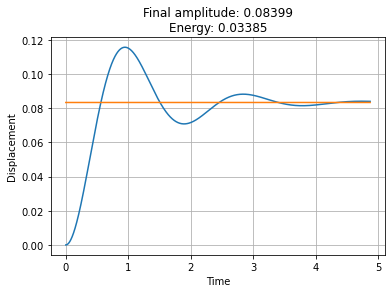

In [12]:
plt.plot(x, traj[:,0])
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.plot(x, force/(2*k)*np.ones(len(x)))
plt.title(f'Final amplitude: {round(traj[-1,0], 5)}\nEnergy: {round(traj[-1,2], 5)}')
plt.grid()

In [13]:
env.getGradients(system)

array([[-0.0109216 , -0.00175644,  0.00148399]])

# Cantilever

We can add a cantilever and an optomechanical coupling to add a non linearity in the displacement

In [14]:
m_cant = 10
b_cant = 10
k_cant = 5
gamma = 10

In [15]:
dofName = 'cantilever'
system.degreesOfFreedom[f'{dofName}'] = spr.ParametricVariable(m_cant)
system.degreesOfFreedom[f'{dofName}'].parameterized = True
system.interactionPotentials[f'{dofName}_K'] =  spr.IntegerPotential(k_cant)
system.interactionPotentials[f'{dofName}_K'].degreesOfFreedom[dofName] = 2
system.interactionPotentials[f'{dofName}_K'].strength.parameterized = True

system.interactionPotentials[f'{dofName}_B'] =  spr.LocalDamping(dofName, b_cant)
system.interactionPotentials[f'{dofName}_B'].strength.parameterized = True

In [16]:
system.interactionPotentials[f'OptoCoup_oscillator_cantilever'] =  spr.IntegerPotential(-gamma)
system.interactionPotentials[f'OptoCoup_oscillator_cantilever'].degreesOfFreedom['oscillator'] = 2
system.interactionPotentials[f'OptoCoup_oscillator_cantilever'].degreesOfFreedom['cantilever'] = 1
system.interactionPotentials[f'OptoCoup_oscillator_cantilever'].strength.parameterized = True
#optomechanical coupling (gamma)

In [17]:
#probe cantilever
system.probes['cantilever'] = spr.WindowedA2Probe('cantilever',
                                                    startIndex=0,
                                                    endIndex=filelength)

# Define an adjoint source (used to compute the gradient efficiently: https://en.wikipedia.org/wiki/Adjoint_state_method)
system.interactionPotentials['cantilever_probe'] = system.probes['cantilever'].makeAdjointSource()

In [18]:
%%time
traj = env.getTrajectories(system, initialConditions=np.zeros(2), deleteTemp=False)

CPU times: user 3.05 ms, sys: 1.08 ms, total: 4.13 ms
Wall time: 572 ms


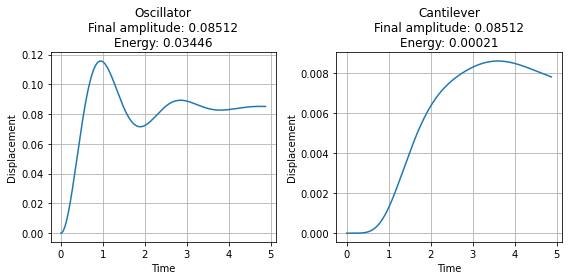

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].plot(x, traj[:,0])
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Displacement')
axs[0].set_title(f'Oscillator\nFinal amplitude: {round(traj[-1,0], 5)}\nEnergy: {round(traj[-1,-2], 5)}')
axs[0].grid()

axs[1].plot(x, traj[:,1])
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Displacement')
axs[1].set_title(f'Cantilever\nFinal amplitude: {round(traj[-1,0], 5)}\nEnergy: {round(traj[-1,-1], 5)}')
axs[1].grid()

plt.tight_layout()

In [20]:
env.getGradients(system)

array([[-1.15654e-02, -1.83265e-03, -1.32861e-04, -3.73025e-05,
        -1.68298e-04,  1.54942e-03, -1.02365e-06]])

# Duffing

We can add a duffing potential to the cantilever

In [21]:
duffing  = 1e5 #lambda

In [22]:
dofName = 'cantilever'
system.interactionPotentials[f'{dofName}_L'] =  spr.IntegerPotential(duffing)
system.interactionPotentials[f'{dofName}_L'].degreesOfFreedom[dofName] = 4
system.interactionPotentials[f'{dofName}_L'].strength.parameterized = True
#duffing potential (lambda)

In [23]:
env = spr.CPPEnvironment(numSteps = filelength,
                           timeStep = 1.0/sr,
                           numSweepSteps = 1,
                           numThreads=1)

In [24]:
traj_duffing = env.getTrajectories(system)

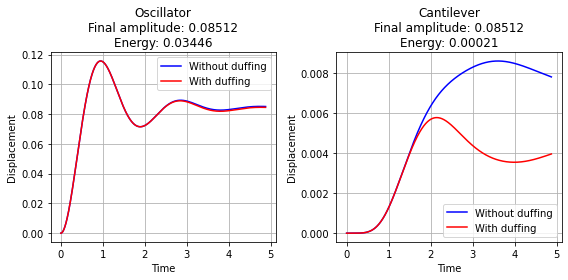

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].plot(x, traj[:,0], 'b', label='Without duffing')
axs[0].plot(x, traj_duffing[:,0], 'r', label='With duffing')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Displacement')
axs[0].set_title(f'Oscillator\nFinal amplitude: {round(traj[-1,0], 5)}\nEnergy: {round(traj[-1,-2], 5)}')
axs[0].grid()
axs[0].legend()

axs[1].plot(x, traj[:,1], 'b', label='Without duffing')
axs[1].plot(x, traj_duffing[:,1], 'r', label='With duffing')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Displacement')
axs[1].set_title(f'Cantilever\nFinal amplitude: {round(traj[-1,0], 5)}\nEnergy: {round(traj[-1,-1], 5)}')
axs[1].grid()
axs[1].legend()
plt.tight_layout()

In [26]:
gradient = env.getGradients(system, deleteTemp=False)
print(gradient)
# 1, 2, 4, 5


[[-1.11797e-02 -1.76847e-03 -2.78996e-05  7.53260e-07 -6.27256e-05
  -1.25552e-09  1.44881e-03 -1.76140e-07]]


# Excitation with audio file

In [27]:
filelength = 78001
sr = 256000
x = np.linspace(0, 2*filelength/sr, filelength)

In [28]:
file = '/home/louvet/Documents/01_data/00_one_to_four/training/soundfile_4'

In [29]:
system.excitationSources['soundData']  = spr.BinaryFileSource(fileList=[file],
                                                                fileLength=filelength,
                                                                fileDataType='double',
                                                                log2Upsampling=2)
system.interactionPotentials[f'excitation'] = spr.Excitation('oscillator', 'soundData', 1.0)

In [30]:
""" env = spr.CPPEnvironment(numSteps = filelength,
                           timeStep = 1.0/sr,
                           numSweepSteps = 1,
                           numThreads=1) """

' env = spr.CPPEnvironment(numSteps = filelength,\n                           timeStep = 1.0/sr,\n                           numSweepSteps = 1,\n                           numThreads=1) '

In [33]:
res = env.getTrajectories(system)

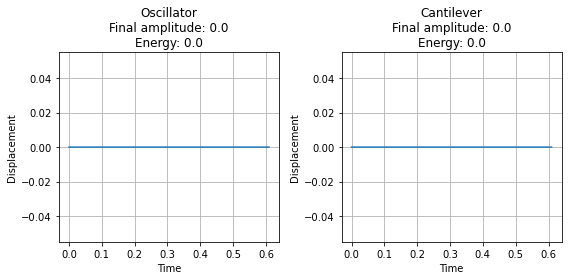

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].plot(x, res[:,0])
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Displacement')
axs[0].set_title(f'Oscillator\nFinal amplitude: {round(res[-1,0], 5)}\nEnergy: {round(res[-1,-2], 5)}')
axs[0].grid()

axs[1].plot(x, res[:,1])
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Displacement')
axs[1].set_title(f'Cantilever\nFinal amplitude: {round(res[-1,0], 5)}\nEnergy: {round(res[-1,-1], 5)}')
axs[1].grid()
plt.tight_layout()

In [35]:
env.getGradients(system)

array([[0., 0., 0., 0., 0., 0., 0., 0.]])

# Matrices

In [121]:
import Springtronics.LinearSimulation as ls

linPoint = ls.makeZeroVector(system)
M, B, K = ls.makeLinearizedModel(system, linPoint)
print("M = ", M)
print("B = ", B)
print("K = ", K)

M =  [[ 1.  0.]
 [ 0. 10.]]
B =  [[ 2.  0.]
 [ 0. 10.]]
K =  [[12.  0.]
 [ 0. 10.]]


In [122]:
state_size = 8 #2*(2 dofs + 2 probes)
adjoint_size = state_size + 4 #2 stiffnesses and 2 dampings

In [151]:
K_dims = [adjoint_size, adjoint_size]
K_values = [1, 1, 1, 1, -2*k/m, -b/m, -2*k_cant/m_cant, -b_cant/m_cant]
K_indexes = [4, 0, 5, 1, 6, 2, 7, 3, 0, 4, 4, 4, 1, 5, 5, 5]
print("K_dims: ", K_dims)
print("K_values: ", K_values)
print("K_indexes: ", K_indexes)

K_dims:  [12, 12]
K_values:  [1, 1, 1, 1, -12.0, -2.0, -1.0, -1.0]
K_indexes:  [4, 0, 5, 1, 6, 2, 7, 3, 0, 4, 4, 4, 1, 5, 5, 5]


In [124]:
Gamma_dims = [adjoint_size, adjoint_size, state_size]
Gamma_values = [-2*gamma/m, -2*gamma/m, -1/m, -1/m, -2*gamma/m_cant, -1/m_cant, -1/m_cant, 1, 1]
Gamma_indexes = [0, 4, 1, 1, 4, 0, 8, 4, 0, 9, 4, 4, 0, 5, 0, 10, 5, 1, 11, 5, 5, 0, 6, 0, 1, 7, 1]
print("Gamma_dims: ", Gamma_dims)
print("Gamma_values: ", Gamma_values)
print("Gamma_indexes: ", Gamma_indexes)


Gamma_dims:  [12, 12, 8]
Gamma_values:  [-20.0, -20.0, -1.0, -1.0, -2.0, -0.1, -0.1, 1, 1]
Gamma_indexes:  [0, 4, 1, 1, 4, 0, 8, 4, 0, 9, 4, 4, 0, 5, 0, 10, 5, 1, 11, 5, 5, 0, 6, 0, 1, 7, 1]


In [150]:
Lambda_dims = [adjoint_size, adjoint_size, state_size, state_size]
Lambda_values = [4*duffing/m_cant]
Lambda_indexes = [1, 5, 1, 1]
print("Lambda_dims: ", Lambda_dims)
print("Lambda_values: ", Lambda_values)
print("Lambda_indexes: ", Lambda_indexes)

Lambda_dims:  [12, 12, 8, 8]
Lambda_values:  [40000.0]
Lambda_indexes:  [1, 5, 1, 1]
